In [1]:
#
# Copyright © 2019 Sunho Kim. All rights reserved.
#

In [2]:
from pyspark.sql import SparkSession, DataFrame

spark = SparkSession\
    .builder\
    .appName('Cluster Books')\
    .getOrCreate()
sc = spark.sparkContext

In [3]:
# parameters
k = 2
iteration = 100

In [5]:
import pyspark.sql.functions as F
from pyspark.ml.feature import CountVectorizer, Normalizer
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix

from gorani.spark import read_data_all, write_data
from gorani.utils import sparse_to_array

SIMILARITY_TYPE = 'cosine'

words = read_data_all(spark, 'words', cache = True)
books = read_data_all(spark, 'books')
print('book list:')
books.select('id','name').orderBy('id').show()

+---+--------------------+
| id|                name|
+---+--------------------+
|  1|Valentin Haüy - t...|
|  2|Valentin Haüy - t...|
|  3|Valentin Haüy - t...|
+---+--------------------+



In [13]:
cv = CountVectorizer()\
    .setInputCol('content')\
    .setOutputCol('tf')\
    .setVocabSize(words.count())
cv = cv.fit(books)

nor = Normalizer()\
    .setInputCol('tf')\
    .setOutputCol('norm')

# normalized book-wordcount matrix
tf_mat = nor.transform(cv.transform(books))

# convert to SparseMatrix to BlockMatrix
mat = IndexedRowMatrix(
tf_mat.select("id", "norm")\
    .rdd.map(lambda row: IndexedRow(row['id'], row['norm'].toArray())))\
    .toBlockMatrix()

# cosine similarity
sim_mat_df = mat.multiply(mat.transpose())\
    .toIndexedRowMatrix()\
    .rows.toDF()

# change schema
sim_af = sim_mat_df.select(F.col('index').alias('id'), F.posexplode(sparse_to_array('vector')))\
    .select('id', F.col('pos').alias('other_id'), F.col('col').alias('value'))\
    .where('id < other_id AND id != 0')\
    .rdd.map(lambda x: tuple([x['id'], x['other_id'], float(x['value'])]))


sim mat:


Text(0.5, 1, 'Book similarity matrix')

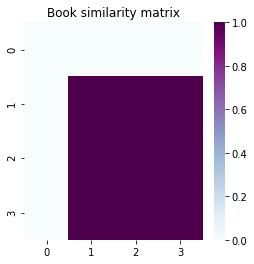

In [11]:
cords = sim_af.collect()
size = books.count() + 1
matrix = [[0 for x in range(size)] for y in range(size)] 
for cord in cords:
    matrix[cord[0]][cord[0]] = 1
    matrix[cord[1]][cord[1]] = 1
    matrix[cord[0]][cord[1]] = cord[2]
    matrix[cord[1]][cord[0]] = cord[2]

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(size,size))
r = sns.heatmap(matrix, cmap='BuPu')
r.set_title("Book similarity matrix")

In [12]:
from pyspark.mllib.clustering import PowerIterationClustering, PowerIterationClusteringModel
from pyspark.sql import Row

model = PowerIterationClustering.train(sim_af, k, iteration)
df = model.assignments().toDF()

write_data('cluster_books', df)
write_data('book_cluster', df)

print('result:')
books.select('id', 'name').join(df, df['id']==books['id'], 'inner').select('cluster','name').orderBy('cluster').show()

result
+-------+--------------------+
|cluster|                name|
+-------+--------------------+
|      0|Valentin Haüy - t...|
|      0|Valentin Haüy - t...|
|      1|Valentin Haüy - t...|
+-------+--------------------+

